In [1]:
#Imports

## General Imports
import numpy as np

## Visualization
import seaborn
import matplotlib.pyplot as plt
import IPython.display as ipd
from ipywidgets import interactive_output #http://ipywidgets.readthedocs.io/en/latest/index.html
from ipywidgets import IntSlider, FloatSlider, fixed, Checkbox
from ipywidgets import VBox, Label


## Audio Imports
import librosa, librosa.display           #https://librosa.github.io/librosa/index.html
from midiutil import MIDIFile             #http://midiutil.readthedocs.io/en/1.2.1/
from music21.tempo import MetronomeMark   #http://web.mit.edu/music21/
from music21.note import Note, Rest
from music21.stream import Stream
from music21 import metadata
from music21 import instrument
from music21 import midi 
from music21.key import Key

In [25]:
plt.rc("figure", figsize=(16,8))

In [3]:
# Parameters
## Signal Processing 
fs = 44100                               # Sampling Frequency
nfft = 2048                              # length of the FFT window
overlap = 0.5                            # Hop overlap percentage
hop_length = int(nfft*(1-overlap))       # Number of samples between successive frames
n_bins = 72                              # Number of frequency bins
mag_exp = 4                              # Magnitude Exponent
pre_post_max = 6                         # Pre- and post- samples for peak picking
cqt_threshold = -61                      # Threshold for CQT dB levels, all values below threshold are set to -120 dB

In [4]:
hop_length

1024

In [27]:
# Load Audio
# Loadinging audio file
filename = "../data/grandpiano.wav"
x, fs = librosa.load(filename, sr=None, mono=True, duration=12)
# Audio data information
print("x Shape=", x.shape)
print("Sample rate fs=", fs)
print("Audio Length in seconds=%d [s]" % (x.shape[0]/fs))
# Playback audio file
ipd.Audio(x, rate=fs)

x Shape= (529200,)
Sample rate fs= 44100
Audio Length in seconds=12 [s]


In [28]:
# CQT vs FFT

# CQT Frequencies
cqt_freqs = librosa.core.cqt_frequencies(n_bins=128, fmin=librosa.note_to_hz('C0'), bins_per_octave=12)

# FFT Frequencies
fft_freqs = librosa.fft_frequencies(sr=44100, n_fft=128)

# Notes Center Frequencies
notes_freqs = 440*2**(np.arange(-57, (128-57))/12)

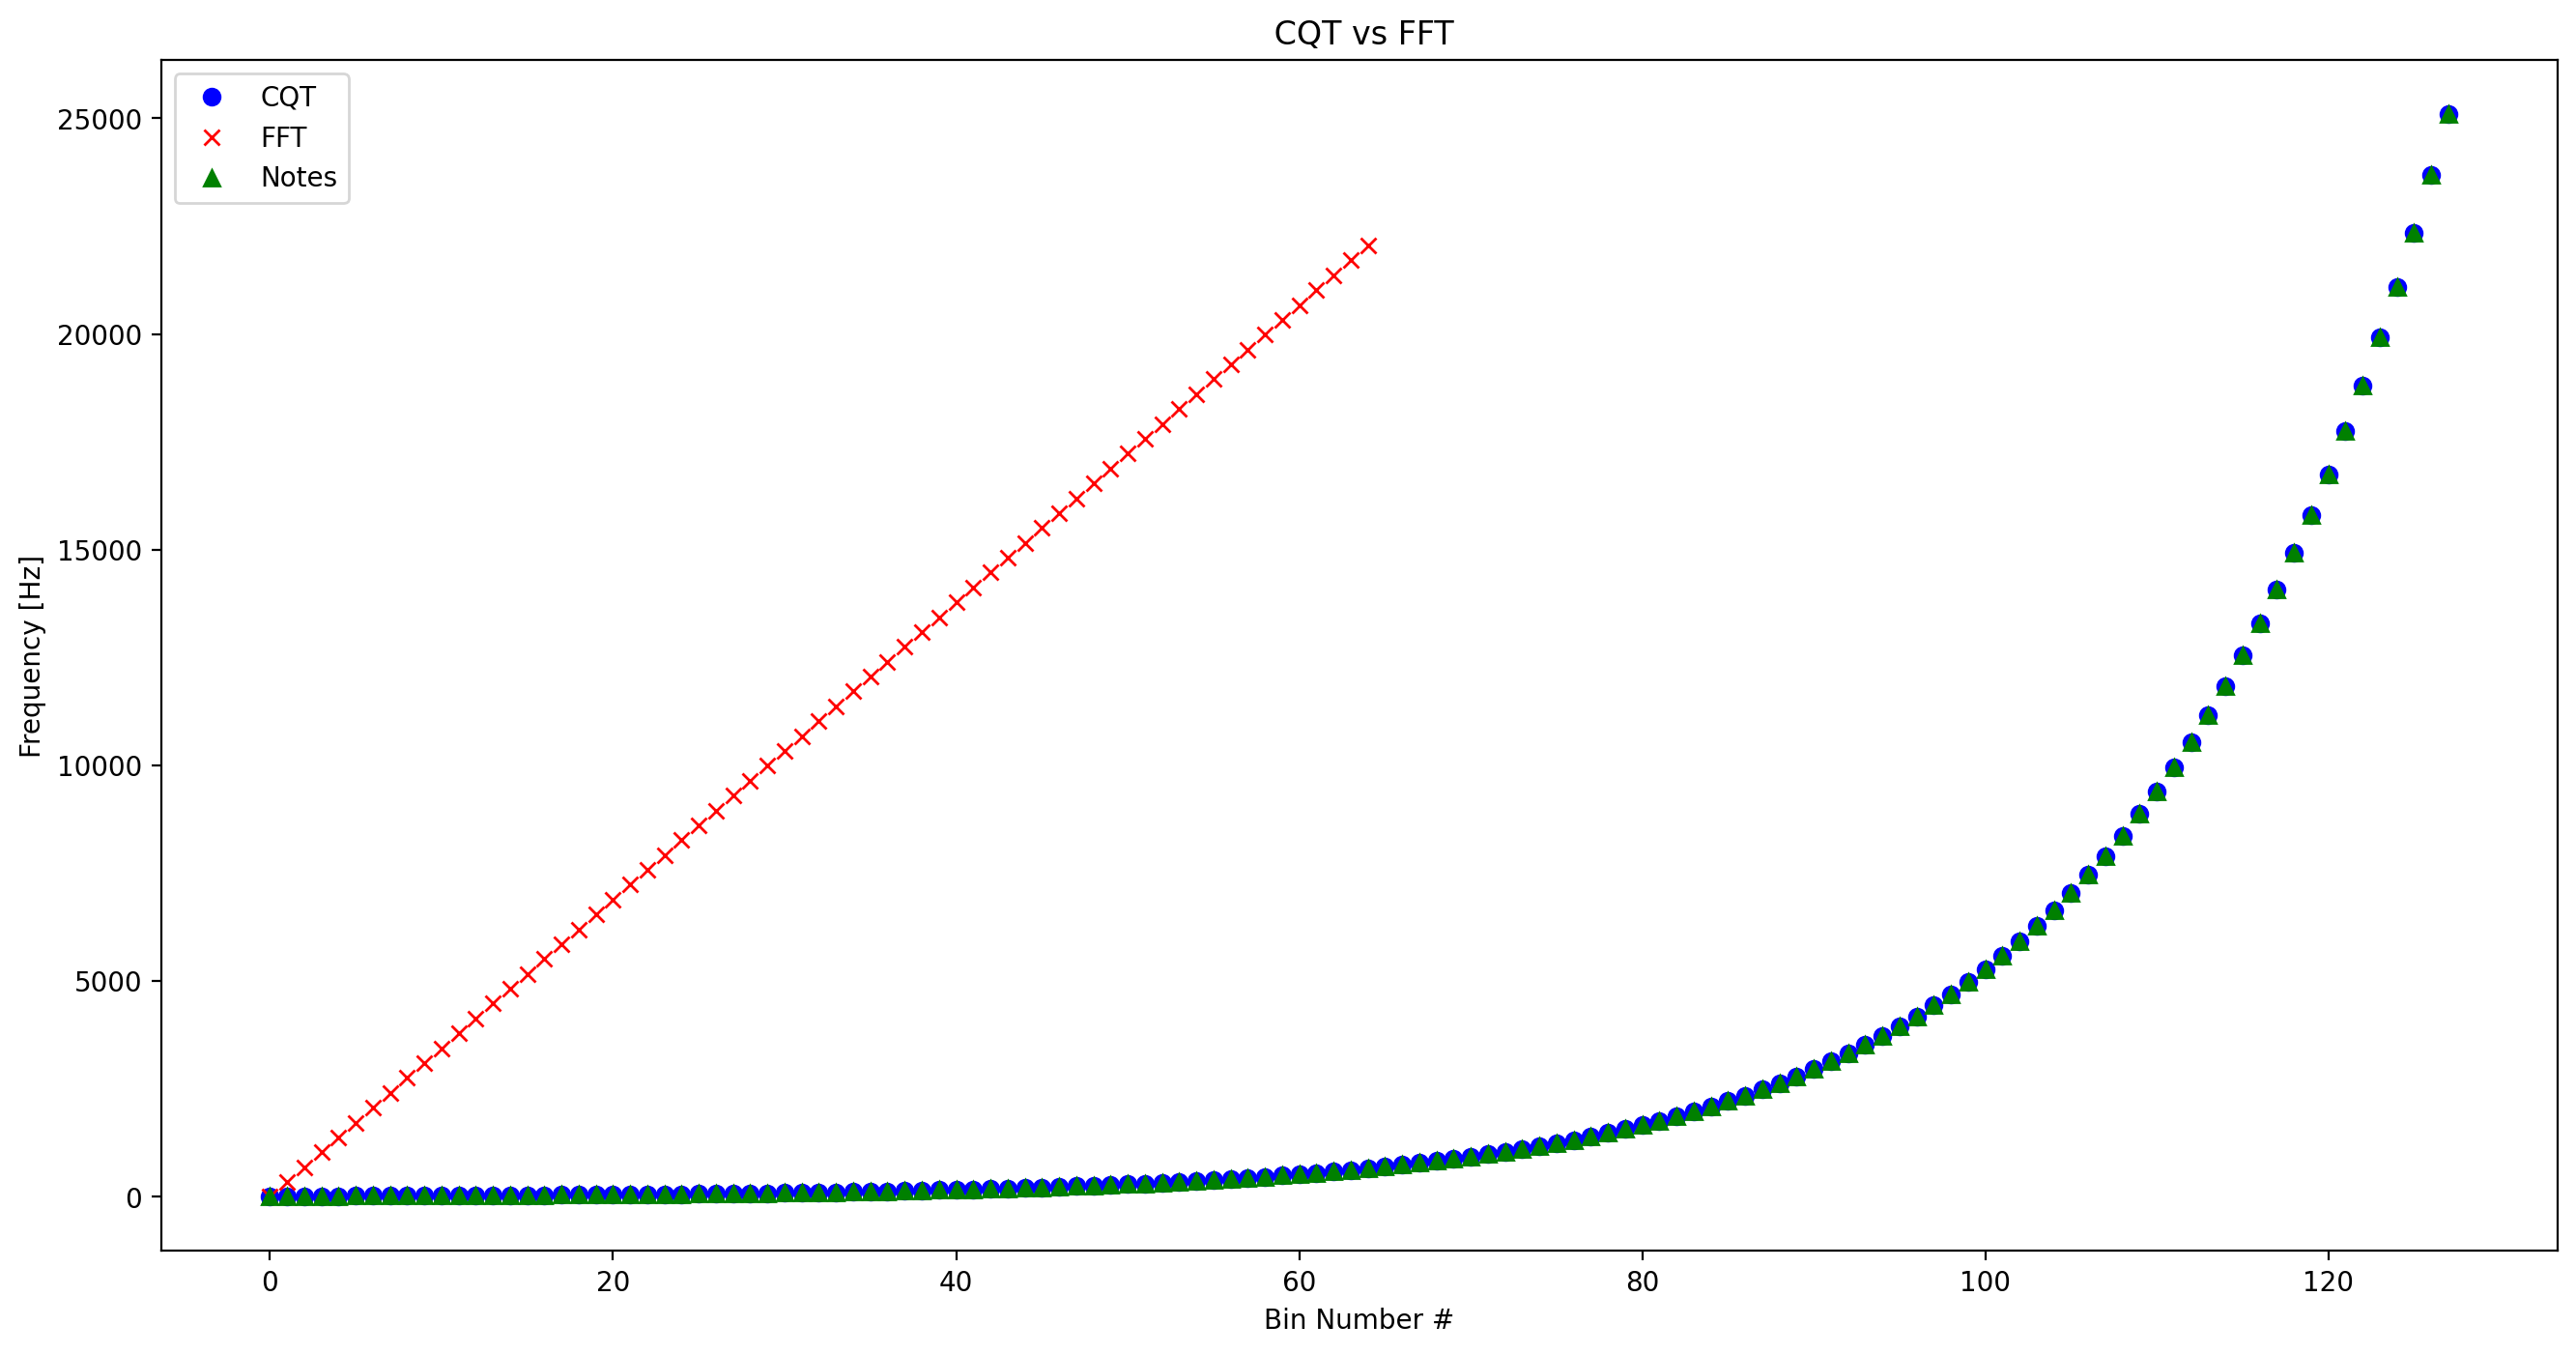

In [29]:
# Plot CQT vs FFT
plt.figure()
plt.plot(cqt_freqs, 'bo', label='CQT')
plt.plot(fft_freqs, 'rx', label= 'FFT')
plt.plot(notes_freqs, 'g^', label = 'Notes')
plt.title(" CQT vs FFT")
plt.xlabel('Bin Number #')
plt.ylabel('Frequency [Hz]')
plt.legend();

In [30]:
# CQT
## Function
def calc_cqt(x,fs=fs,hop_length=hop_length, n_bins=n_bins, mag_exp=mag_exp):
    C = librosa.cqt(x, sr=fs, hop_length=hop_length, fmin=None, n_bins=n_bins)
    C_mag = librosa.magphase(C)[0]**mag_exp
    CdB = librosa.core.amplitude_to_db(C_mag ,ref=np.max)
    return CdB
    

In [31]:
# CQT Threshold
def cqt_thresholded(cqt,thres=cqt_threshold):
    new_cqt=np.copy(cqt)
    new_cqt[new_cqt<thres]=-120
    return new_cqt

In [32]:
# Onset Envelope from Cqt
def calc_onset_env(cqt):
    return librosa.onset.onset_strength(S=cqt, sr=fs, aggregate=np.mean, hop_length=hop_length)

In [33]:
# Onset from Onset Envelope
def calc_onset(cqt, pre_post_max=pre_post_max, backtrack=True):
    onset_env=calc_onset_env(cqt)
    onset_frames = librosa.onset.onset_detect(onset_envelope=onset_env,
                                           sr=fs, units='frames', 
                                           hop_length=hop_length, 
                                           backtrack=backtrack,
                                           pre_max=pre_post_max,
                                           post_max=pre_post_max)
    onset_boundaries = np.concatenate([[0], onset_frames, [cqt.shape[1]]])
    onset_times = librosa.frames_to_time(onset_boundaries, sr=fs, hop_length=hop_length)
    return [onset_times, onset_boundaries, onset_env]

In [34]:
# Fine Tuning UI
style = {'description_width': 'initial'}
mag_exp_slider=IntSlider(value=mag_exp, min=1, max=32, step=1, 
                         description='mag_exp:',continuous_update=False)

thres_slider=IntSlider(value=cqt_threshold, min=-120, max=0, step=1, 
                                                     description='Threshold:',continuous_update=False)

pre_post_slider=IntSlider(value=pre_post_max, min=1, max=32, step=1, 
                         description='Pre_post_max:',continuous_update=False, style=style)

backtrack_box=Checkbox(value=False,description='backtrack',disabled=False)


def inter_cqt_tuning(mag_exp,thres,pre_post_max, backtrack):
    thres=thres_slider.value
    mag_exp=mag_exp_slider.value
    pre_post_max=pre_post_slider.value
    backtrack=backtrack_box.value
    global CdB
    CdB = calc_cqt(x,fs,hop_length, n_bins, mag_exp)
    plt.figure()
    new_cqt=cqt_thresholded(CdB,thres)
    librosa.display.specshow(new_cqt, sr=fs, hop_length=hop_length, x_axis='time', y_axis='cqt_note', cmap='coolwarm')
    plt.ylim([librosa.note_to_hz('B2'),librosa.note_to_hz('B6')])
    global onsets
    onsets=calc_onset(new_cqt,pre_post_max, backtrack)
    plt.vlines(onsets[0], 0, fs/2, color='k', alpha=0.8)
    plt.title("CQT - PianoIntro")
    plt.colorbar()
    plt.show()

In [43]:
# Display UI
out = interactive_output(inter_cqt_tuning,  {'mag_exp': mag_exp_slider, 'thres': thres_slider, 
                                             'pre_post_max': pre_post_slider, 'backtrack':backtrack_box})
ui = VBox([mag_exp_slider, thres_slider, pre_post_slider, backtrack_box])
display(ui, out)

Output()

In [36]:
# Estimate Tempo
tempo, beats=librosa.beat.beat_track(y=None, sr=fs, onset_envelope=onsets[2], hop_length=hop_length,
               start_bpm=120.0, tightness=100, trim=True, bpm=None,
               units='frames')
tempo=int(2*round(tempo/2))
mm = MetronomeMark(referent='quarter', number=tempo)

In [37]:
# Convert Seconds to Quarter-Notes
def time_to_beat(duration, tempo):
    return (tempo*duration/60)

In [38]:
# Remap input to 0-1 for Sine Amplitude or to 0-127 for MIDI
def remap(x, in_min, in_max, out_min, out_max):
    return (x - in_min) * (out_max - out_min) / (in_max - in_min) + out_min

In [39]:
# Generate Sinewave, MIDI Notes and music21 notes
def generate_sine_midi_note(f0_info, sr, n_duration, round_to_sixtenth=True):
    f0=f0_info[0]
    A=remap(f0_info[1], CdB.min(), CdB.max(), 0, 1)
    duration = librosa.frames_to_time(n_duration, sr=fs, hop_length=hop_length)
    #Generate Midi Note and music21 note
    note_duration = 0.02*np.around(duration/2/0.02) # Round to 2 decimal places for music21 compatibility
    midi_duration = time_to_beat(duration, tempo)
    midi_velocity=int(round(remap(f0_info[1], CdB.min(), CdB.max(), 0, 127)))
    if round_to_sixtenth:
        midi_duration=round(midi_duration*16)/16
    if f0==None:
        midi_note=None
        note_info=Rest(type=mm.secondsToDuration(note_duration).type)
        f0=0
    else:
        midi_note=round(librosa.hz_to_midi(f0))
        note = Note(librosa.midi_to_note(midi_note), type=mm.secondsToDuration(note_duration).type)
        note.volume.velocity = midi_velocity
        note_info = [note]
    midi_info = [midi_note, midi_duration, midi_velocity]
            
    # Generate Sinewave
    n = np.arange(librosa.frames_to_samples(n_duration, hop_length=hop_length ))
    sine_wave = A*np.sin(2*np.pi*f0*n/float(sr))
    return [sine_wave, midi_info, note_info]

In [40]:
#Estimate Pitch
def estimate_pitch(segment, threshold):
    freqs = librosa.cqt_frequencies(n_bins=n_bins, fmin=librosa.note_to_hz('C1'),
                            bins_per_octave=12)
    if segment.max()<threshold:
        return [None, np.mean((np.amax(segment,axis=0)))]
    else:
        f0 = int(np.mean((np.argmax(segment,axis=0))))
    return [freqs[f0], np.mean((np.amax(segment,axis=0)))]

In [41]:
# Generate notes from Pitch estimation
def estimate_pitch_and_notes(x, onset_boundaries, i, sr):
    n0 = onset_boundaries[i]
    n1 = onset_boundaries[i+1]
    f0_info = estimate_pitch(np.mean(x[:,n0:n1],axis=1),threshold=cqt_threshold)
    return generate_sine_midi_note(f0_info, sr, n1-n0)

In [42]:
# Array of music information - Sinewave, MIDI Notes and muisc21 Notes
music_info = np.array([
    estimate_pitch_and_notes(CdB, onsets[1], i, sr=fs)
    for i in range(len(onsets[1])-1)
])

DurationException: Unknown type: inexpressible